In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt

import json
import os
import re
import torch

from collections import Counter, defaultdict
from itertools import islice

%matplotlib inline

In [2]:
def get_results(
                task:str,
                version:str,
                model:str,
                task_setting:str,
                aux=None,
):
    subdir = './results_train/' if version == 'train' else './results_test/'
    subsubdir = subdir + task + '/' + model + '/' + task_setting + '/'
    subsubdir = subsubdir + aux + '/' if model == 'adversarial' else subsubdir
    all_files = list(map(lambda f: subsubdir + f, os.listdir(subsubdir)))
    all_results = defaultdict(dict)
    for file in all_files: #islice(all_files, 1, None):
        if not re.search(r'.ipynb_checkpoints', file):
            with open(file) as f:
                r = json.load(f)
                for metric, values in r.items():
                    all_results[file][metric] = values
    return dict(all_results)

def plot_results(
                 results:dict,
                 task:str,
                 model:str,
                 task_setting:str,
                 iv:str='datasets',
                 metric:str='',
                 aux=None,
                 correlation:bool=False,
):
    r_plot = defaultdict(dict) if correlation else {}
    for clf, r in results.items():
        for m, v in r.items():
            if correlation:
                if re.search(r'' + 'batch_f1', m):
                    r_plot[clf]['train'] = v
                elif re.search(r'' + 'val_f1', m):
                    r_plot[clf]['val'] = v
            else:
                if re.search(r'' + metric, m):
                    r_plot[clf] = v
    
    if iv == 'datasets' and task_setting == 'single':
        params = ['$D_o \cup D_s$', '$D_o$', '$D_s$']
        
    elif iv == 'datasets' and task_setting == 'multi':
        params = ['$D_o \cup D_s$', '$D_s$']
        
    elif model == 'adversarial' and iv == 'methods':
        params = ['$D_o \cup D_s$ ($\mathbf{q, c}$)(simple)', '$D_s$ ($\mathbf{q, c}$) (simple)', 
                  '$D_s$ ($\mathbf{q, a}$) (simple)', 
                  '$D_s$ ($\mathbf{q, a}$) (GRL)', 
                  '$D_o \cup D_s$ ($\mathbf{q, c}$)(GRL)', '$D_s$ ($\mathbf{q, c}$) (GRL)']
    
    if re.search(r'batch_loss', metric):
        plt.figure(figsize=(10, 6), dpi=100)
    else:
        plt.figure(figsize=(8, 4), dpi=80)
    
    # set font sizes
    y_lab_fontsize = 12
    x_lab_fontsize = y_lab_fontsize
    title_fontsize = 13
    
    ax = plt.subplot(111)
        
    for idx, (clf, met) in enumerate(r_plot.items()):
        if correlation:
            try:
                ax.plot(met['train'], met['val'], '-o', label=params[idx])
            except ValueError:
                ax.plot(met['train'][:-1], met['val'], '-o', label=params[idx])
        else:
            ax.plot(range(1, len(met) + 1), met, '-o', label=params[idx])
    
    # hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # only show ticks on the left (y-axis) and bottom (x-axis) spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    if correlation:
        ax.set_ylabel('Val F1', fontsize=y_lab_fontsize)
            
    elif re.search(r'acc', metric): 
        ax.set_ylabel('Exact-match', fontsize=y_lab_fontsize)
    
    elif re.search(r'f1', metric):
        ax.set_ylabel('F1', fontsize=y_lab_fontsize)
    
    elif re.search(r'loss', metric):
        ax.set_yticks(range(1, 7))
        ax.set_ylabel('Loss', fontsize=y_lab_fontsize)
    
    ax.set_xlabel('Train F1' if correlation else 'Evaluation steps', fontsize=x_lab_fontsize) 
    ax.legend(fancybox=True, shadow=True)
    ax.set_title('MTL' + ' ' + model.capitalize() if model == 'adversarial' else model.capitalize(), fontsize=title_fontsize)
    plt.tight_layout()
    
    if model == 'adversarial':
        plt.savefig('./plots/' + 'models/' + task + '/' + model + '/' + task_setting + '/' + aux + '/' + metric + '.png')
    elif model == 'adversarial' and correlation:
        plt.savefig('./plots/' + 'models/' + task + '/' + model + '/' + task_setting + '/'  + aux + '/' +  'train_vs_val' + '.png')
    elif correlation:
        plt.savefig('./plots/' + 'models/' + task + '/' + model + '/' + task_setting + '/'  +  'train_vs_val' + '.png')
    else:
        plt.savefig('./plots/' + 'models/' + task + '/' + model + '/' + task_setting + '/' + metric + '.png')
        
    plt.show()
    plt.clf()
    
def plotting(
             models:list,
             metrics:list,
             task:str,
             version:str,
             task_setting:str,
             iv:str,
             aux=None,
):
    print('===========================')
    print('====== Task: {} ======'.format(task.upper()))
    print('===========================')
    print()
    for i, model in enumerate(models):
        # load results
        if model == 'adversarial':
            all_results = get_results(task=task, version=version, model=model, task_setting='multi', aux=aux)
        else:
            all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
        print('==============================')
        print('====== Model: {} ======'.format(model.upper()))
        print('==============================')
        print()
        for j, metric in enumerate(metrics):
            # plot results
            print('=============================')
            print('===== Metric: {} ====='.format(metric.upper()))
            print('=============================')
            if model == 'adversarial':
                plot_results(all_results, task=task, metric=metric, iv='methods',  model=model, task_setting='multi', aux=aux)
            else:
                plot_results(all_results, task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None)

In [3]:
# specify general hyperparameters
models = ['adversarial', 'linear', 'highway', 'recurrent']
metrics = ['batch_loss', 'batch_acc', 'batch_f1', 'val_f1', 'val_acc', 'val_loss']

task='QA'
version = 'train'
task_setting ='multi'
iv = 'datasets'
aux = 'aux_1'

## Performance over time (evaluation steps)

====== Task: QA ======

====== Model: ADVERSARIAL ======

===== Metric: BATCH_LOSS =====


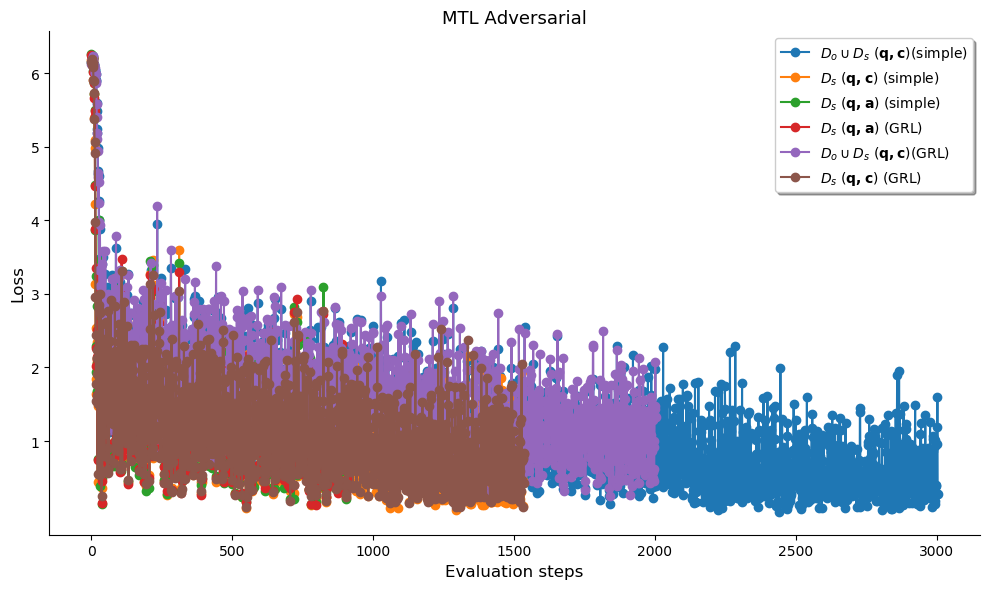

===== Metric: BATCH_ACC =====


<Figure size 432x288 with 0 Axes>

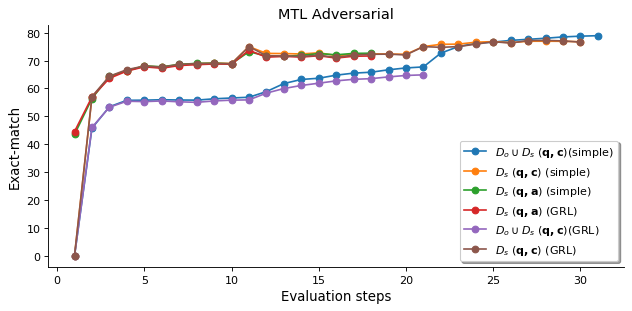

===== Metric: BATCH_F1 =====


<Figure size 432x288 with 0 Axes>

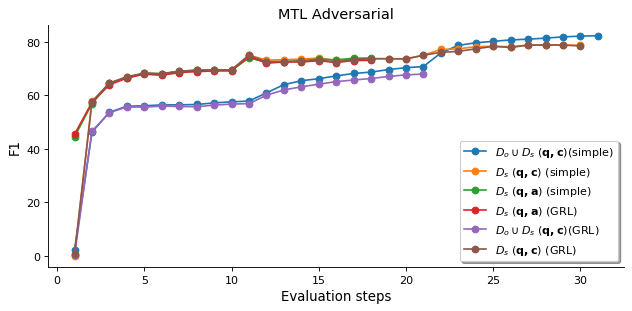

===== Metric: VAL_F1 =====


<Figure size 432x288 with 0 Axes>

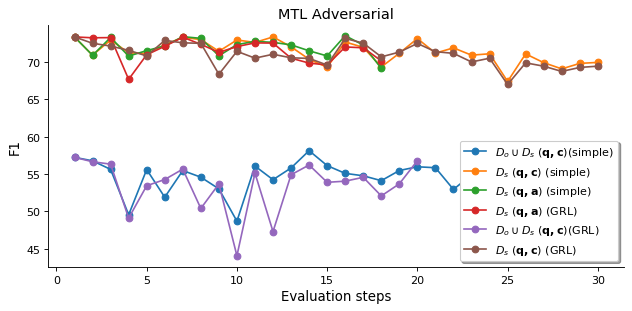

===== Metric: VAL_ACC =====


<Figure size 432x288 with 0 Axes>

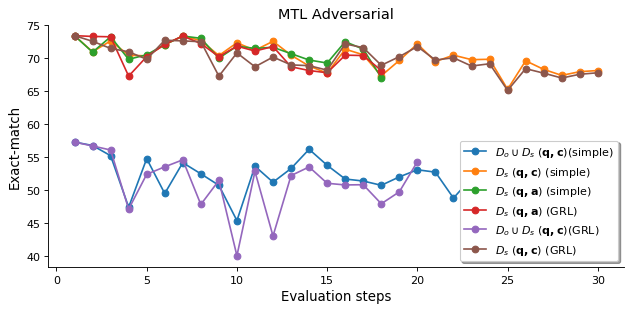

===== Metric: VAL_LOSS =====


<Figure size 432x288 with 0 Axes>

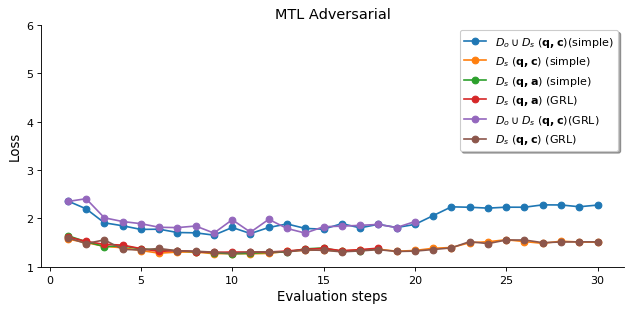

====== Model: LINEAR ======

===== Metric: BATCH_LOSS =====


<Figure size 432x288 with 0 Axes>

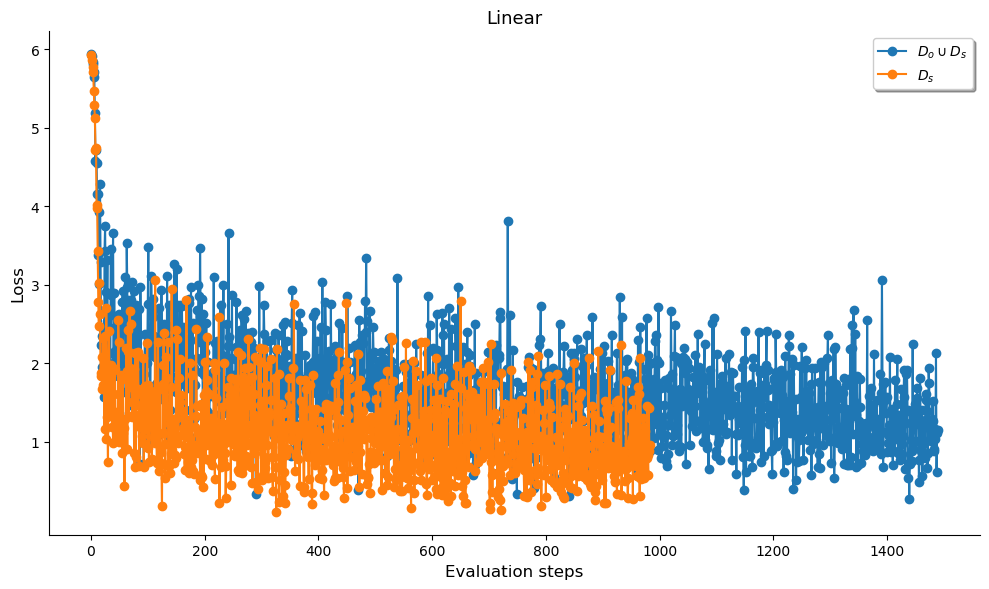

===== Metric: BATCH_ACC =====


<Figure size 432x288 with 0 Axes>

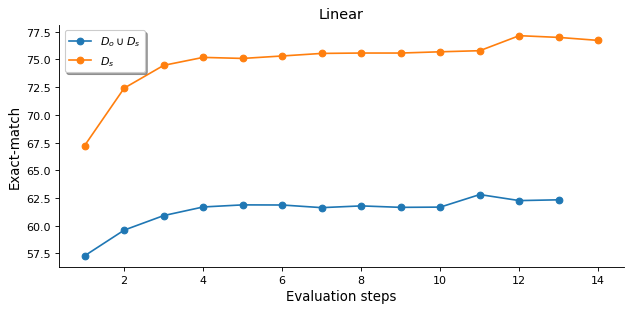

===== Metric: BATCH_F1 =====


<Figure size 432x288 with 0 Axes>

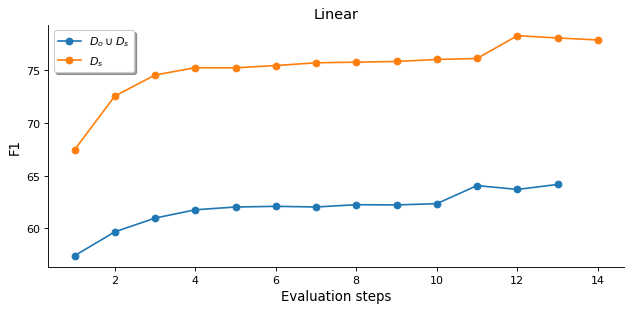

===== Metric: VAL_F1 =====


<Figure size 432x288 with 0 Axes>

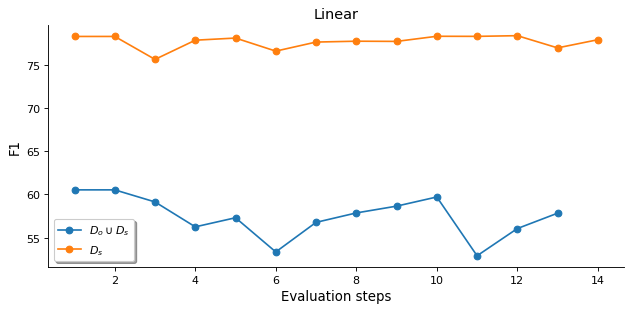

===== Metric: VAL_ACC =====


<Figure size 432x288 with 0 Axes>

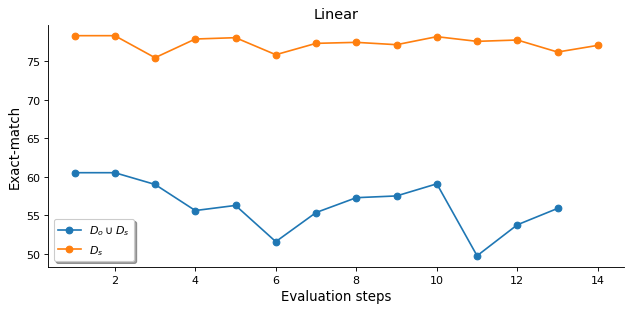

===== Metric: VAL_LOSS =====


<Figure size 432x288 with 0 Axes>

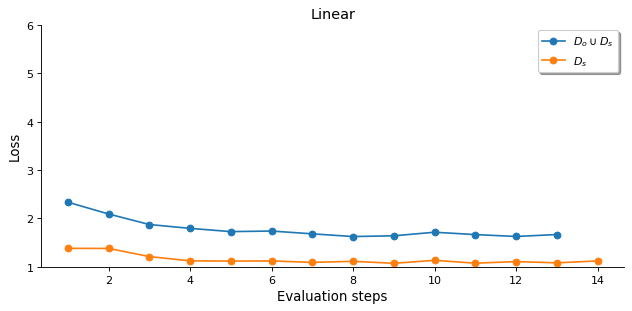

====== Model: HIGHWAY ======

===== Metric: BATCH_LOSS =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

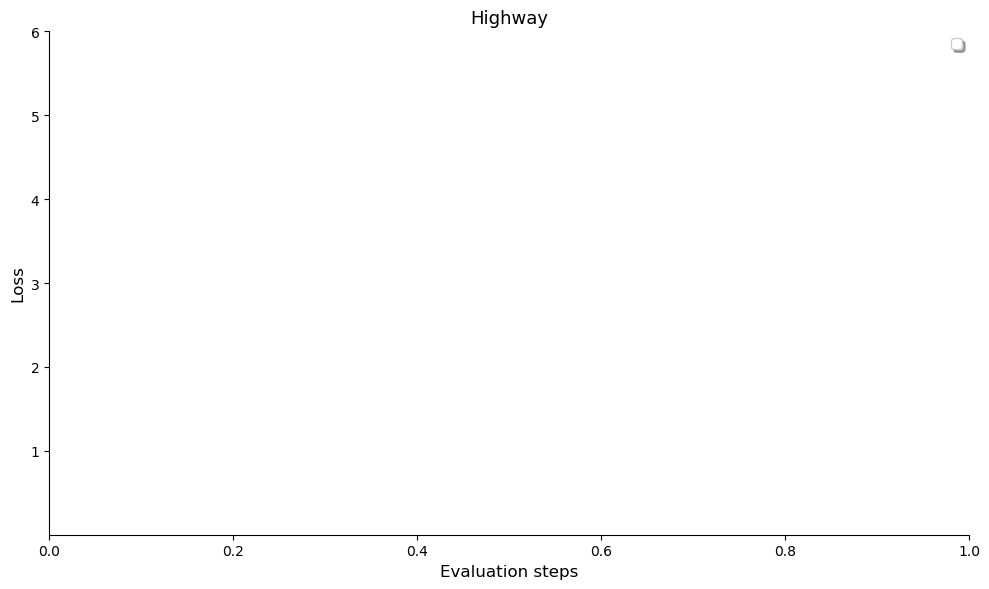

===== Metric: BATCH_ACC =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

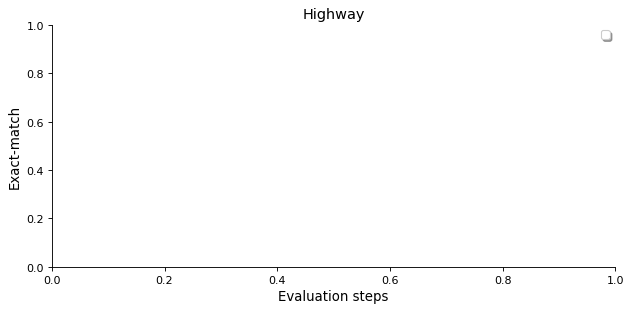

===== Metric: BATCH_F1 =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

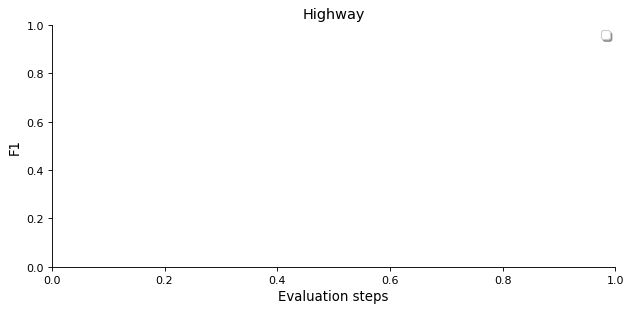

===== Metric: VAL_F1 =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

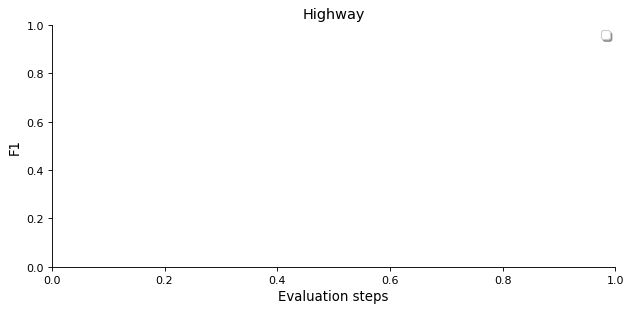

===== Metric: VAL_ACC =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

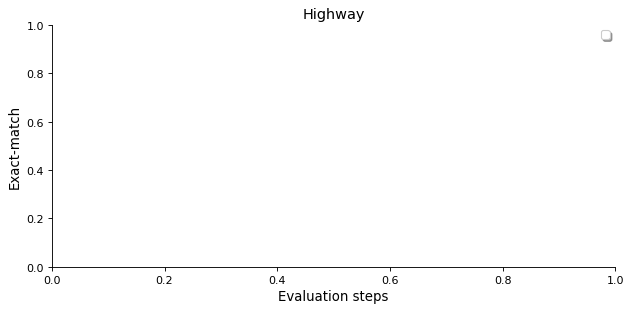

===== Metric: VAL_LOSS =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

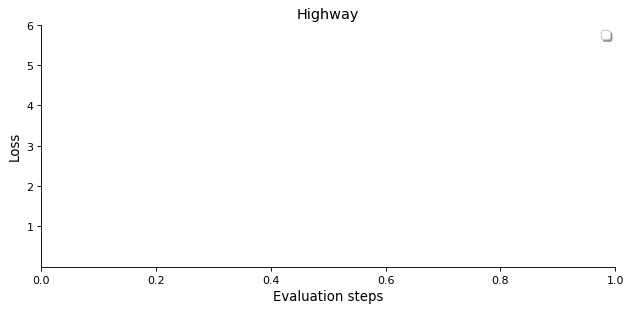

====== Model: RECURRENT ======

===== Metric: BATCH_LOSS =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

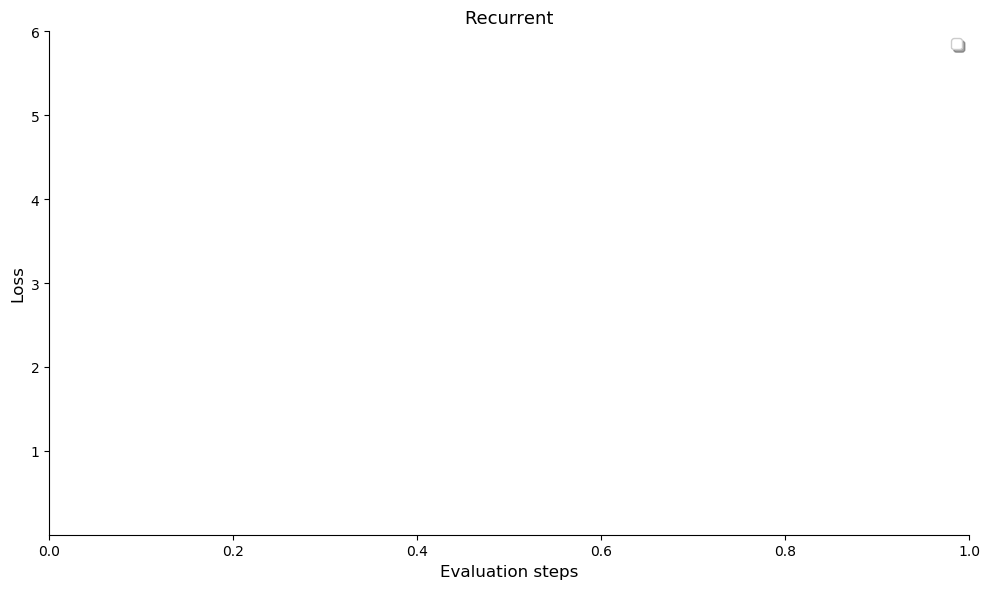

===== Metric: BATCH_ACC =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

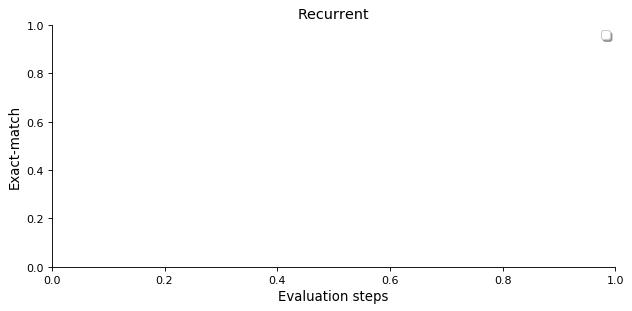

===== Metric: BATCH_F1 =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

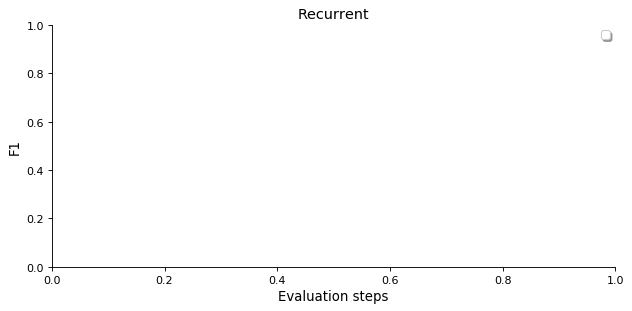

===== Metric: VAL_F1 =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

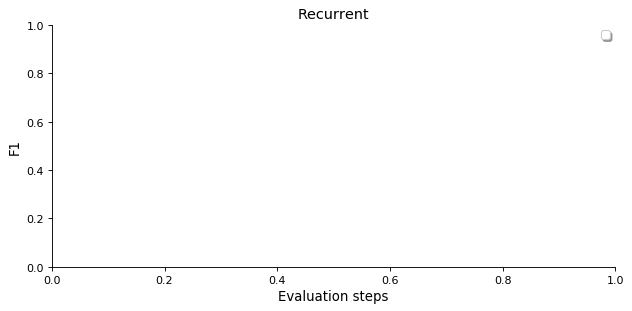

===== Metric: VAL_ACC =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

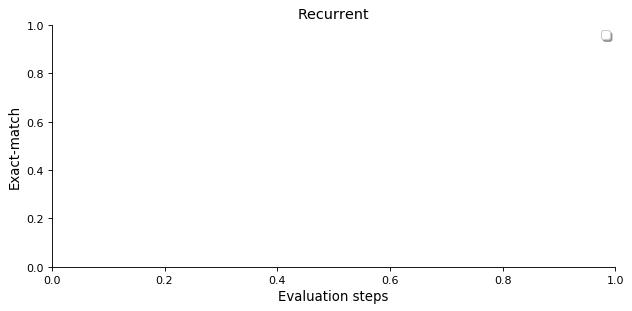

===== Metric: VAL_LOSS =====


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

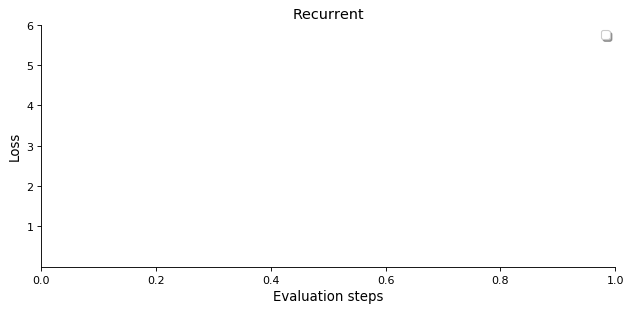

<Figure size 432x288 with 0 Axes>

In [4]:
plotting(models=models, metrics=metrics, task=task, version=version, task_setting=task_setting, iv=iv, aux=aux)

## Performance on dev set as a function of performance on train set 

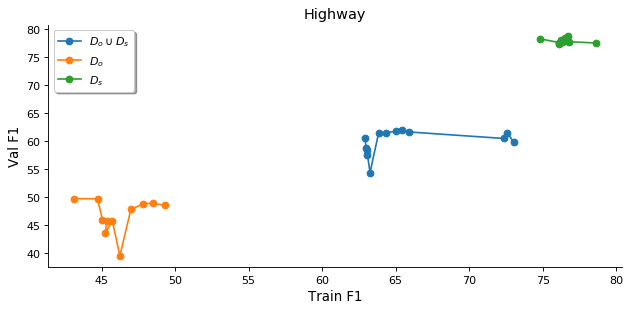

<Figure size 432x288 with 0 Axes>

In [5]:
task = 'QA'
version = 'train'
model = 'highway'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results, task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

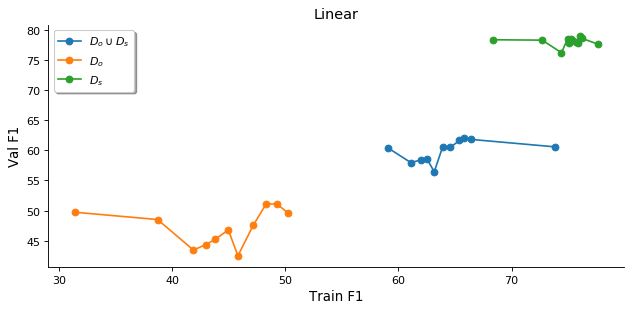

<Figure size 432x288 with 0 Axes>

In [6]:
task = 'QA'
version = 'train'
model = 'linear'
task_setting = 'single'
iv = 'datasets'
metric = ''

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=None)
plot_results(all_results,task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=None, correlation=True)

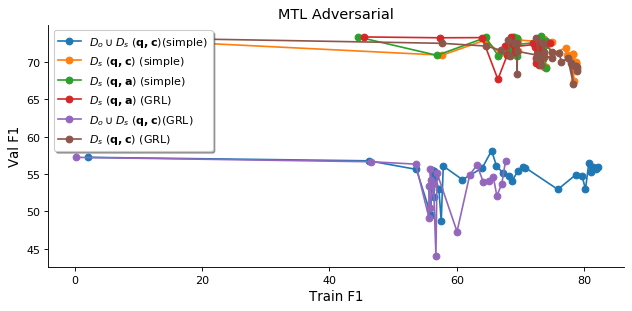

<Figure size 432x288 with 0 Axes>

In [7]:
task = 'QA'
version = 'train'
model = 'adversarial'
task_setting = 'multi'
iv = 'methods'
metric = ''
aux = 'aux_1'

all_results = get_results(task=task, version=version, model=model, task_setting=task_setting, aux=aux)
plot_results(all_results, task=task, metric=metric, iv=iv,  model=model, task_setting=task_setting, aux=aux, correlation=True)